In [1]:
# Model 4 - Recursive Coefficient Estimation

In [2]:
#Importing the Excel file into Python

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Replace 'your_file.csv' with the path to your actual CSV file
data = pd.read_excel("G:/My Drive/Ireland - Jasleen/Trinity/Coursework/Dissertation/Drafts/Analysis and Findings/Country Wise Analysis/S&P 500 CleanData.xlsx")

# Check for missing values and remove rows with missing returns
data = data.dropna(subset=['Return'])

# Display the first few rows of the dataframe
print(data.head(20))

         Date  Unnamed: 1 Day of the week  PX_LAST    Return  \
0  2016-05-09        2019          Monday  2058.69  0.075319   
1  2016-05-10        2018         Tuesday  2084.39  1.240639   
2  2016-05-11        2017       Wednesday  2064.46 -0.960756   
3  2016-05-12        2016        Thursday  2064.11 -0.016955   
4  2016-05-13        2015          Friday  2046.61 -0.851437   
5  2016-05-16        2014          Monday  2066.66  0.974901   
6  2016-05-17        2013         Tuesday  2047.21 -0.945589   
7  2016-05-18        2012       Wednesday  2047.63  0.020514   
8  2016-05-19        2011        Thursday  2040.04 -0.371361   
9  2016-05-20        2010          Friday  2052.32  0.600145   
10 2016-05-23        2009          Monday  2048.04 -0.208762   
11 2016-05-24        2008         Tuesday  2076.06  1.358863   
12 2016-05-25        2007       Wednesday  2090.54  0.695054   
13 2016-05-26        2006        Thursday  2090.10 -0.021049   
14 2016-05-27        2005          Frida

In [3]:
# Defining data range
# Specify the start and end dates of the desired range
start_date = '2016-05-02'
end_date = '2024-05-10'

# Filter the dataframe based on the date range
data = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Print the selected columns
print(data)

           Date  Unnamed: 1 Day of the week  PX_LAST    Return  \
0    2016-05-09        2019          Monday  2058.69  0.075319   
1    2016-05-10        2018         Tuesday  2084.39  1.240639   
2    2016-05-11        2017       Wednesday  2064.46 -0.960756   
3    2016-05-12        2016        Thursday  2064.11 -0.016955   
4    2016-05-13        2015          Friday  2046.61 -0.851437   
...         ...         ...             ...      ...       ...   
1715 2024-05-06           8          Monday  5180.74  1.027314   
1716 2024-05-07           7         Tuesday  5187.70  0.134254   
1717 2024-05-08           6       Wednesday  5187.67 -0.000578   
1718 2024-05-09           5        Thursday  5214.08  0.507800   
1719 2024-05-10           4          Friday  5222.68  0.164802   

                       Week Day of Week  
0     2016-05-09/2016-05-15      Monday  
1     2016-05-09/2016-05-15     Tuesday  
2     2016-05-09/2016-05-15   Wednesday  
3     2016-05-09/2016-05-15    Thursday

In [4]:
# Drop rows with NaT in the 'Date' column
data = data.dropna(subset=['Date'])

# Extract the day of the week from the 'Date' column
data['Day_of_Week'] = data['Date'].dt.day_name()

# Perform one-hot encoding to create dummy variables for each day of the week
data_with_dummies = pd.get_dummies(data, columns=['Day_of_Week'], drop_first=False)

# Check if any of the columns contain boolean values and convert them to integer (0 and 1)
for col in data_with_dummies.columns:
    if data_with_dummies[col].dtype == 'bool':
        data_with_dummies[col] = data_with_dummies[col].astype(int)


# Display the resulting dataframe
data_with_dummies.head()

# import statsmodels.api as sm

# Define the independent variables (dummy variables for days of the week)
X_1 = data_with_dummies[['Day_of_Week_Monday', 
                       'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 
                       'Day_of_Week_Wednesday','Day_of_Week_Friday']]

# Define the dependent variable (Returns)
Y_1 = data_with_dummies['Return']

In [5]:
data_with_dummies.columns

data_with_dummies['Date'] = pd.to_datetime(data_with_dummies['Date'])
data_with_dummies.set_index('Date', inplace=True)

In [6]:
# Recursive Regression Formula

import statsmodels.formula.api as smf
def recursive_reg(variable, i, interval):
    # formula = 'Return ~ Day_of_Week_Monday + Day_of_Week_Thursday + Day_of_Week_Tuesday + Day_of_Week_Wednesday + Day_of_Week_Friday'
    formula = 'Return ~ Day_of_Week_Monday'
    results = smf.ols(formula, data_with_dummies.iloc[:i+interval]).fit()
    coeff=results.params[variable]
    se=results.bse[variable]

    return coeff, se

In [7]:
# Generate SE and Coefficients for each day of the week

parameters = [] 
for i in range (0, len(data_with_dummies)-5):
    coeff, se = recursive_reg('Day_of_Week_Monday', i, 5)
    parameters.append((coeff, se))

parameters=pd.DataFrame(parameters, columns=['coeff', 'se']\
                        , index=data_with_dummies.index[5:])
parameters['Day_of_Week_Monday + 2*se'] = parameters['coeff'] + 2*parameters['se']
parameters['Day_of_Week_Monday - 2*se'] = parameters['coeff'] - 2*parameters['se']

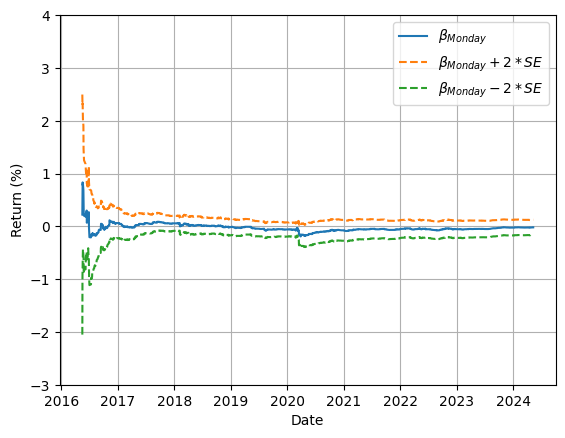

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(parameters['coeff'], label=r'$\beta_{Monday}$')
plt.plot(parameters['Day_of_Week_Monday + 2*se'], label=r'$\beta_{Monday} + 2*SE$', linestyle='dashed')
plt.plot(parameters['Day_of_Week_Monday - 2*se'], label=r'$\beta_{Monday} - 2*SE$', linestyle='dashed')
plt.ylim(-3, 4)
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.show()